In [1]:
import torch
from torchvision import transforms
from torchvision import datasets as ch_datasets

from robustness import datasets as dataset_utils

from standard_utils import *
from decision_tree_utils import *
from visualize_utils import *

In [2]:
def load_robust_model(imagenet_path):
    dataset_function = getattr(dataset_utils, 'ImageNet')
    dataset = dataset_function('')

    model_kwargs = {
        'arch': 'resnet50',
        'dataset': dataset,
        'resume_path': f'./models/robust_resnet50.pth',
        'parallel': False
    }
    model, _ = model_utils.make_and_restore_model(**model_kwargs)
    model.eval()
    return model

# Failure explanation sample

In [3]:
from sklearn.feature_selection import mutual_info_classif

def mutual_info_select_features(train_features_class, train_failure_class, 
                                num_features=20):
    mi = mutual_info_classif(train_features_class, train_failure_class, 
                             random_state = 0)
    important_features_indices = np.argsort(mi)[-num_features:]
    important_features_values = mi[important_features_indices]
    return important_features_indices, important_features_values

# Find classes with highest failure rate
def top_failure_classes(train_logits, train_labels, k, grouping='label'):
    train_failure_dict = failure_statistics(train_logits, train_labels)
    if grouping == 'label':
        label_failures_arr = train_failure_dict['label_failures']
        label_counts_arr = train_failure_dict['label_counts']
        label_fractions_arr = label_failures_arr/label_counts_arr
        num_classes_half = train_logits.shape[1]//2
        top_k_indices = np.argsort(-label_fractions_arr)[0:k]
    elif grouping == 'pred':
        pred_failures_arr = train_failure_dict['pred_failures']
        pred_counts_arr = train_failure_dict['pred_counts']
        pred_fractions_arr = pred_failures_arr/pred_counts_arr

        num_remove = (pred_counts_arr < 1000).sum()
        pred_fractions_arr = pred_failures_arr/pred_counts_arr
        pred_fractions_arr[pred_counts_arr<1000] = 0.
        pred_fractions_indices = np.argsort(-pred_fractions_arr)[:-num_remove]
        top_k_indices = pred_fractions_indices[0:k]
    else:
        raise Exception('Unknown grouping', grouping)
    return top_k_indices

# Find indices where predicted or label class (depending on grouping) is class_idx
def failure_indices_class(train_logits, train_labels, class_idx, class_names, 
                          grouping='label', print_stats=True):
    train_failure_dict = failure_statistics(train_logits, train_labels)
    if grouping == 'label':
        if print_stats:
            class_name, num_failures, num_preds, num_labels = print_failure_stats_label(
                train_failure_dict, class_idx, class_names)
        train_indices_class = np.nonzero(train_labels==class_idx)[0]
    elif grouping == 'pred':
        if print_stats:
            class_name, num_failures, num_preds, class_names = print_failure_stats(
                train_failure_dict, class_idx, class_names)
        train_indices_class = predicted_class_indices(train_logits, class_idx)
    return train_indices_class

# Perform feature selection using some prespecified method such as mutual_information
def select_important_features(train_features, train_failure, num_features=20, 
                              method='mutual_info'):
    if method == 'mutual_info':
        important_indices, _ = mutual_info_select_features(
                                            train_features, 
                                            train_failure, 
                                            num_features=num_features)
        train_sparse_features = train_features[:, important_indices]
    else:
        raise ValueError('Unknown feature selection method') 
    return train_sparse_features, important_indices
            
# Train decision tree
def train_decision_tree(train_sparse_features, train_failure, max_depth=1, criterion="entropy"):
    num_true = np.sum(train_failure)
    num_false = np.sum(np.logical_not(train_failure))
    rel_weight = num_false/num_true
    class_weight_dict = {0: 1, 1: rel_weight}

    decision_tree = CustomDecisionTreeClassifier(
        max_depth=max_depth, criterion=criterion, class_weight=class_weight_dict)
    decision_tree.fit_tree(
        train_sparse_features, train_failure)
    return decision_tree

# Select leaf nodes with highest importance value i.e highest contribution to average leaf error rate
def important_leaf_nodes(decision_tree, precision_array, recall_array):
    leaf_ids = decision_tree.leaf_ids
    leaf_precision = precision_array[leaf_ids]
    leaf_recall = recall_array[leaf_ids]
    leaf_precision_recall = leaf_precision*leaf_recall

    important_leaves = np.argsort(-leaf_precision_recall)
    return leaf_ids[important_leaves]

In [4]:
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd

class FailureExplanationDataset(Dataset):
    """Failure Explanation Dataset."""

    def __init__(self, root, class_name, grouping="label", csv_file=None, 
                 transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            csv_file (string): Path to the csv file with labels and predictions.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root = root
        self.images_dir = os.path.join(root, 'images')
        
        if csv_file is not None:
            metadata_filename = os.path.join(root, csv_file)
        else:
            metadata_filename = os.path.join(root, 'metadata.csv')
        self.metadata_frame = pd.read_csv(metadata_filename)
        
        if grouping == "label":
            select_indices = (self.metadata_frame["Labels"] == class_name)
        else:
            select_indices = (self.metadata_frame["Predictions"] == class_name)
        self.metadata_frame = self.metadata_frame[select_indices]

        class_names_labels = self.metadata_frame["Labels"].to_numpy()
        class_names_preds = self.metadata_frame["Predictions"].to_numpy()
        class_names = np.concatenate([class_names_preds, class_names_labels])
        
        unique_class_names = np.unique(class_names)
        self.class_indices_dict = dict(zip(unique_class_names, np.arange(len(unique_class_names))))
        
        self.transform = transform

    def __len__(self):
        return len(self.metadata_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir,
                                self.metadata_frame.iloc[idx, 0])
        prediction = self.metadata_frame.iloc[idx, 1]
        label = self.metadata_frame.iloc[idx, 2]
        
        img = Image.open(img_name)
        img = img.convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label, prediction

In [5]:
def sample_failure_explanation(dataset_path, class_name, grouping = "label"):
    robust_model_name = 'robust_resnet50.pth'
    robust_model = load_robust_model('/scratch1/shared/datasets/ILSVRC2012/')
    
    data_transform = transforms.Compose([transforms.ToTensor()])
    sample_dataset = FailureExplanationDataset(root=dataset_path, class_name=class_name, 
                                               grouping=grouping, transform=data_transform)
    
    batch_size = 32
    data_loader = torch.utils.data.DataLoader(sample_dataset,
                                              batch_size=batch_size, 
                                              shuffle=False, num_workers=4)
    
    train_features, train_preds, train_labels = [], [], []
    total = 0
    for _, (ims, labels, preds) in enumerate(data_loader):
        ims = ims.cuda()
        batch_size = ims.shape[0]
        (_, features), _ = robust_model(ims, with_latent=True)
        features = features.detach().cpu().numpy()
        
        labels = np.array(labels)
        preds = np.array(preds)
        
        train_features.append(features)
        train_labels.append(labels)
        train_preds.append(preds)
        
        total = total + batch_size

    train_features = np.concatenate(train_features, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    train_preds = np.concatenate(train_preds, axis=0)
    train_failure = np.logical_not(train_preds == train_labels)
    train_base_error_rate = np.sum(train_failure)/len(train_failure)
    
    important_features_indices = np.arange(train_features.shape[1])

    decision_tree = train_decision_tree(train_features, train_failure, 
                                        max_depth=1, criterion="entropy")
    train_precision, train_recall, train_ALER = decision_tree.compute_precision_recall(
        train_features, train_failure)
    
    train_success = np.logical_not(train_failure)
    print_with_stars(" Training Data Summary ", prefix="\n")
    print('Grouping by {:s} for class name: {:s}'.format(grouping, class_name))
    print('Number of correctly classified: {:d}'.format(np.sum(train_success)))
    print('Number of incorrectly classified: {:d}'.format(np.sum(train_failure)))
    print('Total size of the dataset: {:d}'.format(len(train_failure)))
    print('Train Base_Error_Rate (BER): {:.4f}\n'.format(train_base_error_rate))

    print_with_stars(" Decision Tree Summary (evaluated on training data) ")
    print('Tree Precision: {:.4f}'.format(train_precision))
    print('Tree Recall: {:.4f}'.format(train_recall))
    print('Tree ALER (ALER of the root node): {:.4f}\n'.format(train_ALER))

    
    error_rate_array, error_coverage_array = decision_tree.compute_leaf_error_rate_coverage(
                                                train_features, train_failure)

    important_leaf_ids = important_leaf_nodes(decision_tree, error_rate_array, error_coverage_array)
    for leaf_id in important_leaf_ids[:1]:
        leaf_precision = error_rate_array[leaf_id]
        leaf_recall = error_coverage_array[leaf_id]

        decision_path = decision_tree.compute_decision_path(leaf_id)

        print_with_stars(" Failure statistics for leaf[{:d}] ".format(leaf_id))
        print('Leaf Error_Rate (ER): {:.4f}'.format(leaf_precision))
        print('Leaf Error_Coverage (EC): {:.4f}'.format(leaf_recall))
        print('Leaf Importance_Value (IV): {:.4f}'.format(leaf_precision*leaf_recall))

        
        leaf_failure_indices = decision_tree.compute_leaf_truedata(train_features, 
                                                                   train_failure, leaf_id)
        display_failures(leaf_id, leaf_failure_indices, data_loader, grouping, num_images=6)
        
        print_with_stars(" Decision tree path from root to leaf[{:d}] ".format(leaf_id))
        for node in decision_path:
            node_id, feature_id, feature_threshold, direction = node
            
            if direction == 'left':
                print_str = "Feature[{:d}] < {:.6f} (left branching, lower feature activation)".format(
                    feature_id, feature_threshold)
            else:
                print_str = "Feature[{:d}] > {:.6f} (right branching, higher feature activation)".format(
                    feature_id, feature_threshold)

            print(print_str)
        print("")
        
        print_with_stars(" Visualizing features on path from root to leaf[{:d}] ".format(leaf_id))
        print("")
        display_images(decision_path, data_loader, 
                       robust_model, train_features, grouping, num_images=6)

=> loading checkpoint './models/robust_resnet50.pth'
=> loaded checkpoint './models/robust_resnet50.pth' (epoch 105)


/scratch1/ssingla/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448238472/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



********************************************** Training Data Summary **********************************************
Grouping by label for class name: water jug
Number of correctly classified: 72
Number of incorrectly classified: 72
Total size of the dataset: 144
Train Base_Error_Rate (BER): 0.5000

******************************* Decision Tree Summary (evaluated on training data) ********************************
Tree Precision: 1.0000
Tree Recall: 1.0000
Tree ALER (ALER of the root node): 1.0000

***************************************** Failure statistics for leaf[1] ******************************************
Leaf Error_Rate (ER): 1.0000
Leaf Error_Coverage (EC): 1.0000
Leaf Importance_Value (IV): 1.0000


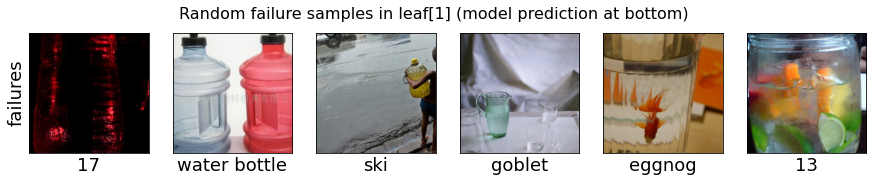

Class index: 17 ==> Class name: jack-o'-lantern
Class index: 13 ==> Class name: goldfish, Carassius auratus

************************************* Decision tree path from root to leaf[1] *************************************
Feature[1378] < 0.089335 (left branching, lower feature activation)

******************************** Visualizing features on path from root to leaf[1] ********************************

******************************************** Visualizing feature[1378] ********************************************


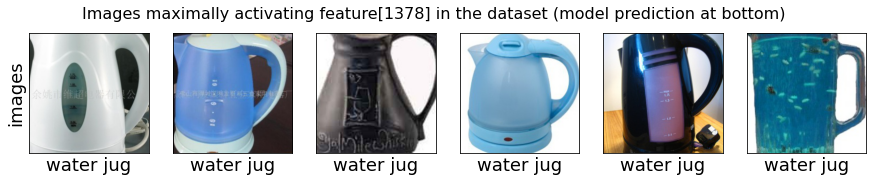

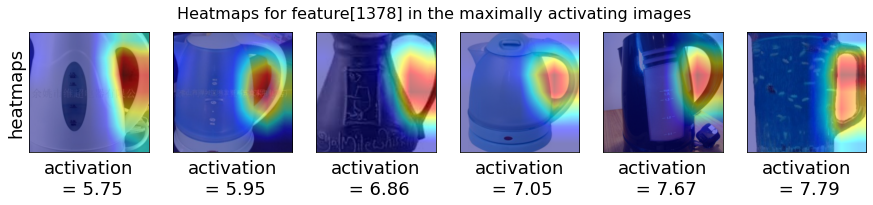

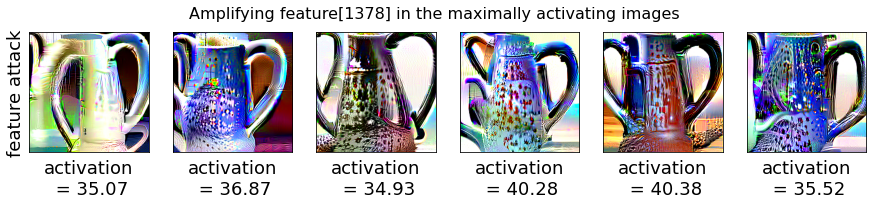

In [6]:
sample_failure_explanation(dataset_path="sample_data", class_name="water jug", grouping="label")